# Using Random Forest Regressor to predict ground-estimate

The code involves using sklearn's random forest regressor to predict ground-estimate based on the 5 algorithms' output, which are treated as features. The code used the larynx microphone data generated form Scherbaum Mshavanadze using CREPE to train the model. RandomizedSearchCV was used to choose the best parameters for the model. 

### Importing Libraries

In [15]:
import numpy as np
import os
import pandas as pd
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [16]:
def separate(adir):
    conv={}
    conv[0] = lambda s: float(s.strip() or 0)
    x,y = np.loadtxt(adir, unpack=True, usecols=(0,1), converters=conv)
    return (x,y)

## Collecting and Organizing Data

In [17]:
data_dir = '/Akamai/voice/data/pitches-vuv/'
collection = 'Scherbaum Mshavanadze'

In [5]:
X = []
y = []

In [6]:
algos = ['crepe', 'hermes', 'maddox', 'noll', 'yin']
data = {algo: {} for algo in algos}

for algo in os.listdir(data_dir):
    if algo not in algos: continue
    for song in os.listdir(f"{data_dir}{algo}/{collection}"):
        for part in os.listdir(f"{data_dir}{algo}/{collection}/{song}"):
            if os.path.isdir(f"{data_dir}{algo}/{collection}/{song}/{part}"): continue
            coll = song[:6]
            label = part[-10:-4]
            x, y = separate(f"{data_dir}{algo}/{collection}/{song}/{part}")            
            if not coll in data[algo]:
                data[algo][coll] = {}
            data[algo][coll][label] = (x, y)
    print(algo, "done")

crepe done
hermes done
maddox done
noll done
yin done


In [7]:
X = []
for algo in data.keys():
    if algo != 'crepe':
        X.append(data[algo])
y = data['crepe']

In [18]:
X = np.array([])
Y = np.array([])

collections = ['AHDS1M', 'AHDS2M', 'AHDS3M', 'ALRX1M', 'ALRX2M', 'ALRX3M']
songs = ['GVM009', 'GVM017', 'GVM019', 'GVM031', 'GVM097']

for song in songs:
    for collection in collections:
        cx = []
        cy = []
        for algo in algos:
            if algo == 'crepe': continue
            cx.append(data[algo][song][collection][1])
            
        if '1' in collection: cy.append(data['crepe'][song]['ALRX1M'][1])
        elif '2' in collection: cy.append(data['crepe'][song]['ALRX2M'][1])
        else: cy.append(data['crepe'][song]['ALRX3M'][1])
        
        if len(X) == 0:
            X = np.transpose(np.array(cx))
            Y = np.transpose(np.array(cy))
        else:
            X = np.vstack((X, np.transpose(np.array(cx))))
            Y = np.vstack((Y, np.transpose(np.array(cy))))

### Training the Model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [21]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.fit_transform(X_test)

In [22]:
scaler = StandardScaler()
scaler.fit(X_poly_train)
X_train_scaled = scaler.transform(X_poly_train)
X_test_scaled = scaler.transform(X_poly_test)

#### Used Polynomial Regression to train the data

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
mean_squared_error(y_test, lin_reg.predict(X_test_scaled))

2446.379822313771

#### Also attempted trained RandomForestRegressor to train the data.

The results were better with Random Forest Regressor

In [ ]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [12, 13, 14, 15, 17, 18],
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

rnd_search = RandomizedSearchCV(RandomForestRegressor(), random_grid, scoring="neg_mean_squared_error", random_state=42, n_iter=10, cv=9, verbose=2)
rnd_search.fit(X_train_scaled, y_train)

In [31]:
mean_squared_error(y_test, rnd_search.predict(X_test_scaled))

1852.7281343362329

### Few examples of how well the RandomForestRegressor performs. 

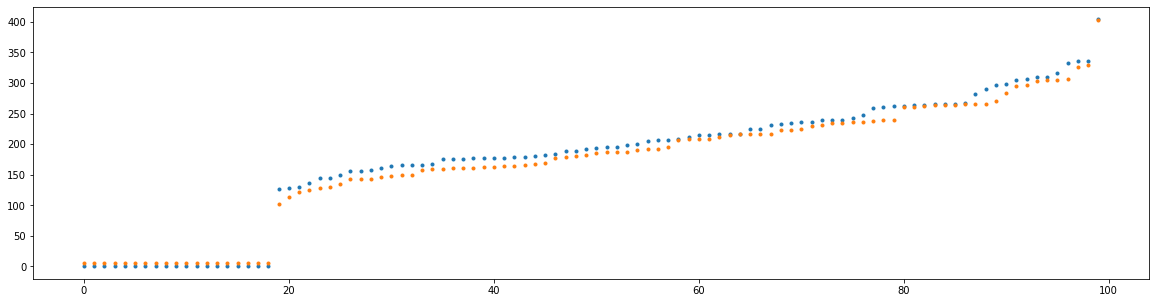

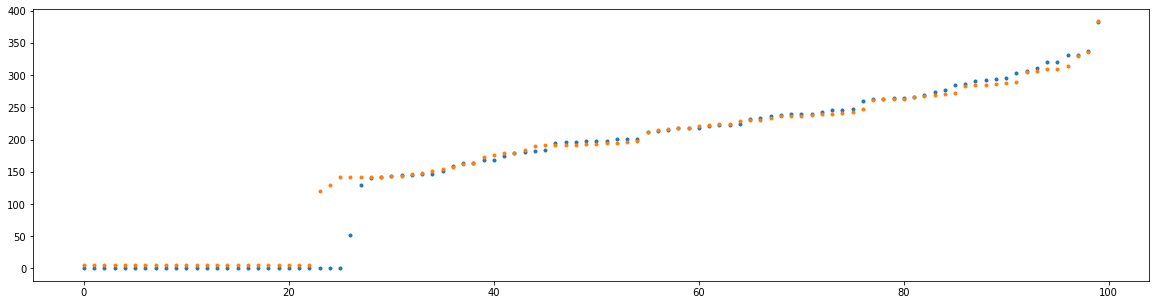

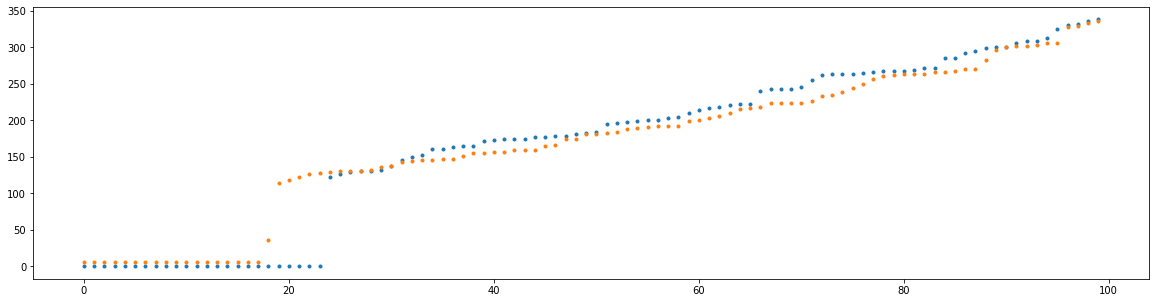

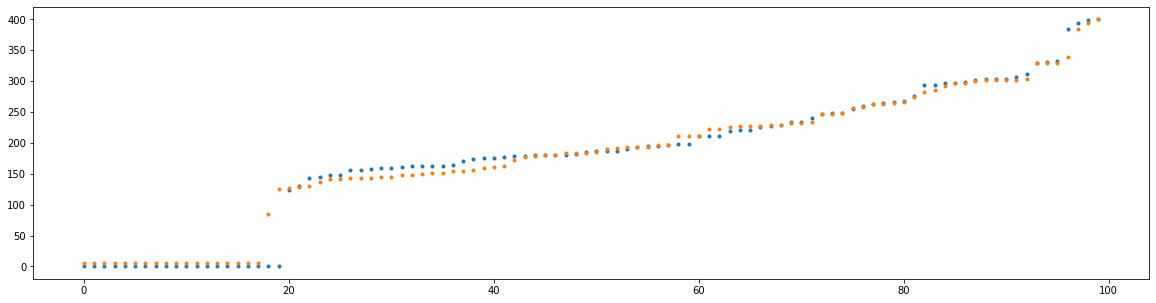

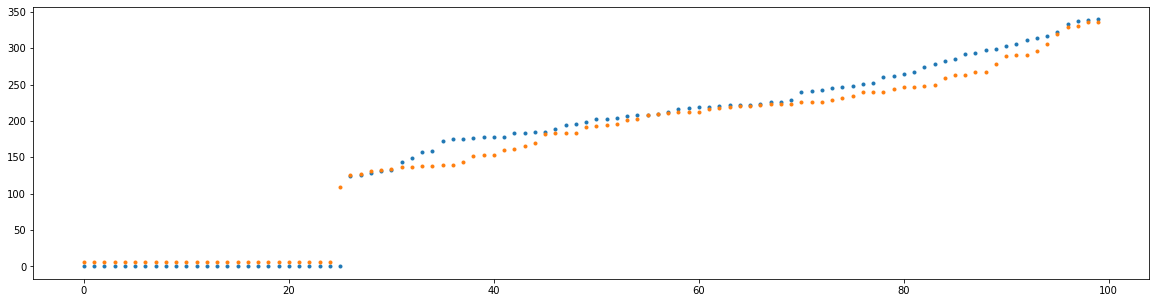

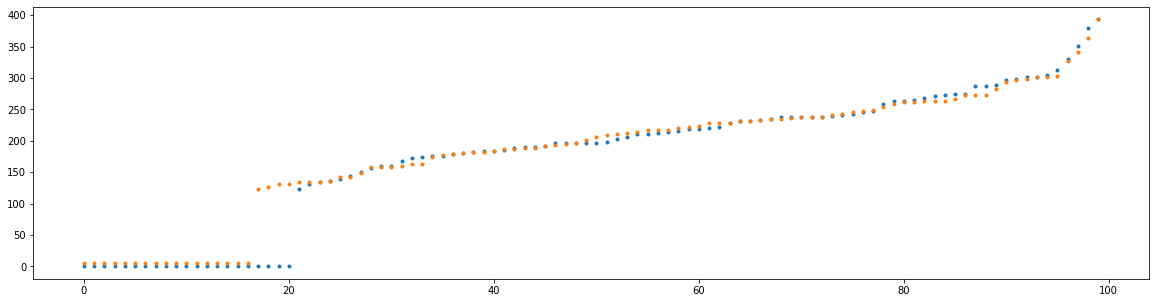

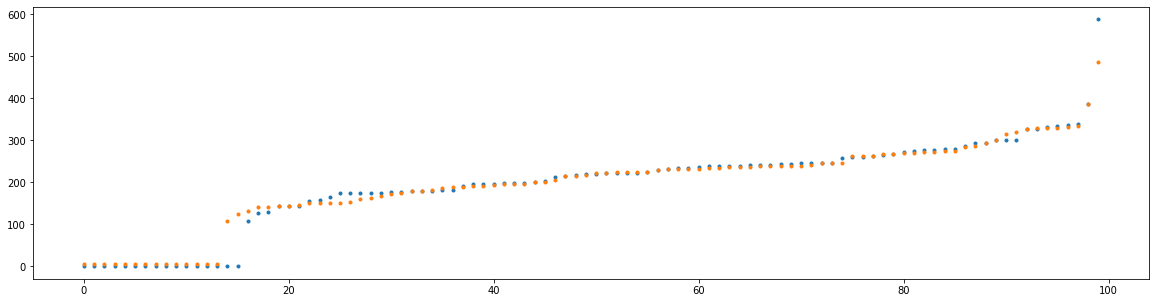

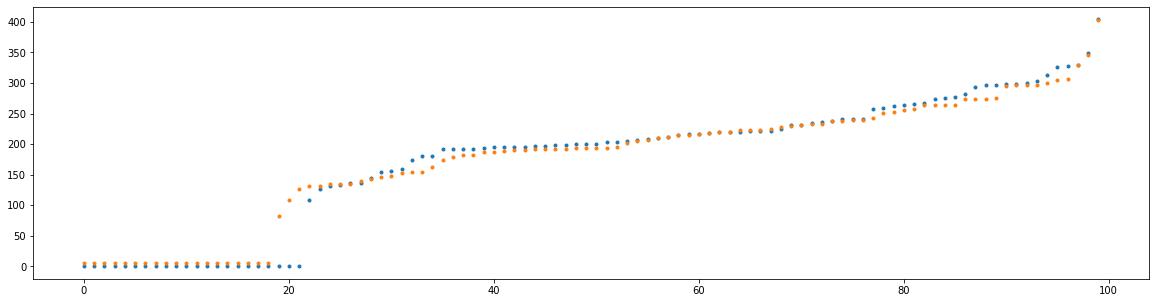

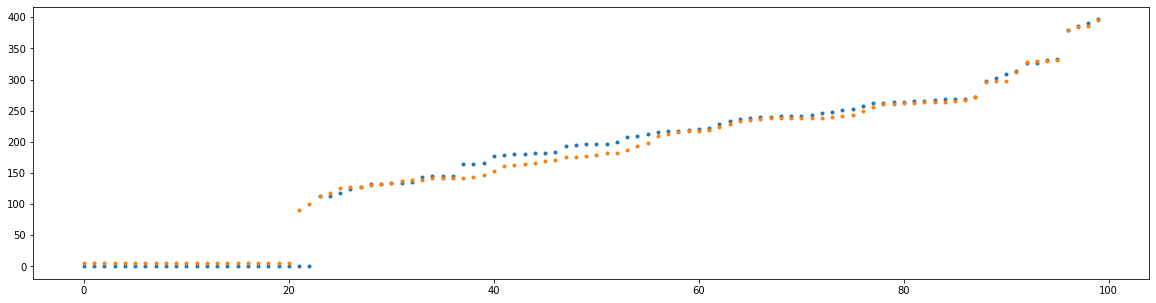

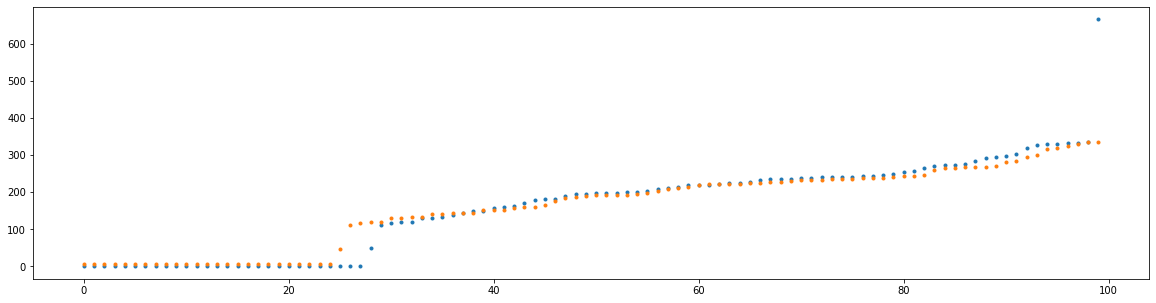

In [33]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure(figsize=(20, 5))
    plt.plot(sorted(y_test[100 * i:100 * i + 100]), '.')
    plt.plot(sorted(rnd_search.predict(X_test_scaled)[100 * i:100 * i + 100]), '.')